In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Checking out the data i was given

In [2]:
from matplotlib import pyplot as plt
#import matplotlib.path as pat
from PIL import Image, ImageDraw, ImageOps
import json
#import timeit
import itertools
#from shapely.geometry import Point, Polygon
import random
import cv2 as cv
import opendatasets as odfrom pathlib import Path


od.download("https://www.kaggle.com/competitions/hubmap-organ-segmentation/data")
mpath = '.'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

plt.rcParams['figure.figsize'] = [15, 10]


df_train = pd.read_csv(mpath + '/hubmap-organ-segmentation/train.csv')
df_test = pd.read_csv(mpath + '/hubmap-organ-segmentation/test.csv')

Skipping, found downloaded files in "./hubmap-organ-segmentation" (use force=True to force download)


Number of images per organ

In [3]:
df_train.columns
organs = df_train.loc[:,"organ"].unique()
amounts = {org : len(df_train.loc[df_train["organ"] == org]) for org in organs}
print(amounts)
organ_example = [np.array(df_train.loc[df_train["organ"] == i].head(1).id) for i in amounts]
print(organ_example)

{'prostate': 93, 'spleen': 53, 'lung': 48, 'kidney': 99, 'largeintestine': 58}
[array([10044]), array([10392]), array([10488]), array([10611]), array([10651])]


Image example

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


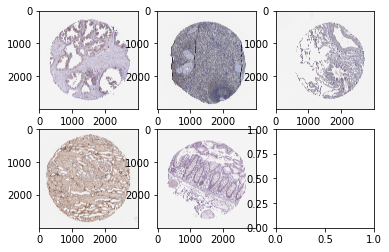

In [4]:
a = [np.array(Image.open(mpath+f'/hubmap-organ-segmentation/train_images/{str(j[0])}.tiff')) for j in organ_example]
#print(a)
masks = [json.load(open(mpath+f'/hubmap-organ-segmentation/train_annotations/{str(j[0])}.json')) for j in organ_example]
fix, ax = plt.subplots(2,3)
print(ax)
count = 0
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(a[count])
        count = count + 1
        if count == len(a):
            break
plt.show()

Applying the polygon mask to the image

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


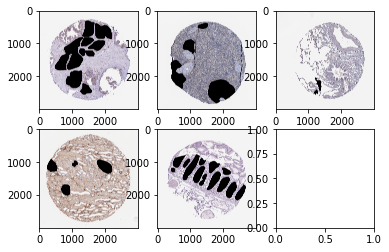

[[[241 241 236]
  [244 242 243]
  [245 243 245]
  ...
  [245 245 244]
  [245 245 244]
  [245 245 245]]

 [[245 245 245]
  [245 245 245]
  [244 245 245]
  ...
  [245 245 245]
  [245 245 245]
  [245 245 245]]

 [[245 245 245]
  [245 245 245]
  [245 243 245]
  ...
  [245 245 245]
  [245 245 245]
  [245 244 244]]

 ...

 [[245 244 244]
  [245 245 245]
  [244 245 245]
  ...
  [245 245 245]
  [243 245 245]
  [245 245 244]]

 [[245 245 245]
  [242 245 245]
  [245 245 245]
  ...
  [245 245 245]
  [245 244 245]
  [245 245 245]]

 [[245 245 245]
  [245 245 245]
  [245 245 245]
  ...
  [245 245 245]
  [245 244 245]
  [245 244 244]]]


In [5]:
#print(mask[0])
a_og = a


fix, ax = plt.subplots(2,3)
print(ax)
count = 0
for i in range(2):
    for j in range(3):
        a_og[count] = Image.fromarray(a[count])
        for m in masks[count]:
            ImageDraw.Draw(a_og[count]).polygon([tuple(u) for u in m], outline=1, fill=1)
        ax[i,j].imshow(a_og[count])
        count = count + 1
        if count == len(a_og):
            break
plt.show()
print(np.array(a_og[0]))

In [6]:
print(df_test["data_source"].tolist())

['Hubmap']


Checking out hubmap

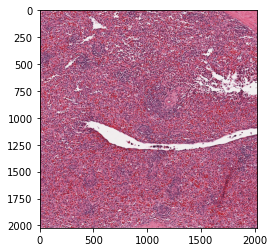

In [7]:
a = Image.open(mpath+'/hubmap-organ-segmentation/test_images/10078.tiff')
mask = json.load(open(mpath+'/hubmap-organ-segmentation/train_annotations/11064.json'))
im = np.array(a)
plt.imshow(im)

Data augmentation:
1. rotation
2. scaling
3. mirroring
4. (can try segmenting the picture)

# Segmentation

Helpers

TODO: 
* check if we can only grab images within the tissue sample for learning(i have a sneaking suspicion that hubmap images don't have any white background)

In [75]:
def maskPIL(im_shape,masks,to_array = True):
    #create empty image of background
    img = Image.new('L',(im_shape),0)
    #we go through the list of masks
    for poly in masks:
        #print(poly)
        ImageDraw.Draw(img).polygon([tuple(u) for u in poly],outline=1,fill=1)
    if to_array:
        return np.array(img, dtype=bool)
    else:
        return img
    

def check_mask_included(mask, height, width,h_len,w_len):
    return 0 < np.sum(mask[height:height+h_len,width:width+w_len])

#im = PIL.Image || np.array, direction = 0(y) || 1(x)
def flip_im(im,direction = 0 ,to_array = True):
    if im is None:
        raise Exception("Image is None") 
        return -1
    #image is a np.array we don't convert
    elif type(im).__module__ == np.__name__:
        return np.flip(im,direction)
    else:
        if direction == 0:
            if to_array:
                return np.array(ImageOps.flip(im))
            return ImageOps.flip(im)
        else:
            if to_array:
                return np.array(ImageOps.mirror(im))
            return ImageOps.mirror(im)

#im = PIL.Image has to be PIL image
def rotate_im(im,rot_amount = 15):
    return im.rotate(angle=rot_amount)
        
        
def otsu_mask_dilated(image,kernel1,kernel2):
    #convert image to greyscale
    grey = np.array(ImageOps.grayscale(image))
    
    
    
    
    
    #apply gaussian blur OPTINAL
    gauss_grey = cv.GaussianBlur(grey,(5,5),0)
    
    
    
    
    #apply otsu thresholding
    thresh,mask = cv.threshold(gauss_grey,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    mask = cv.bitwise_not(mask)
    
    mask = cv.erode(mask,kernel1)
    #
    mask = cv.dilate(mask,kernel2)
    mask = cv.erode(mask,kernel2)
    
    return mask


#PADDING HERE FUCKED NOT FIXED BECAUSE NEVER USED
def get_crop_of_mask(mask,w_slice=0,h_slice = 0,p_h = 0,p_w = 0, coords = False):
    
    maskx = np.any(mask, axis=0)
    masky = np.any(mask, axis=1)
    x1 = np.argmax(maskx)
    y1 = np.argmax(masky)
    x2 = len(maskx) - np.argmax(maskx[::-1])
    y2 = len(masky) - np.argmax(masky[::-1]) 
    #pad if the image is smaller than the pad amount + crop
    h = w = False
    
    padding_h = padding_w = 0
    if p_h+(y2-y1)>mask.shape[0]:
        padding_h = p_h+(y2-y1)-mask.shape[0]
        h = True
    if p_w+(x2-x1)>mask.shape[1]:
        padding_w = p_w+(x2-x1)-mask.shape[1]
        w = True 
    
   

    #w_slice = rand.randint(0,p_w)
    #h_slice = rand.randint(0,p_h)
    pad_front_w = pad_front_h = pad_back_w = pad_back_h = 0

    x1 = x1-w_slice
    if(x1<0):
        pad_front_w = -x1
        x1 = 0    
    y1 = y1-h_slice
    if(y1<0):
        pad_front_h = -y1
        y1 = 0
    #padding is too large
    if(x2+pad_front_w+(p_w-w_slice)>=mask.shape[1]):
        pad_back_w = x2+pad_front_w+(p_w-w_slice) -mask.shape[1] 
        x2 = mask.shape[1]
    if(y2+pad_front_h+(p_h-h_slice)>=mask.shape[0]):
        pad_back_h = y2+pad_front_h+(p_h-h_slice) - mask.shape[0]
        y2 = mask.shape[0]

    if(w or h):
        print(pad_front_h,pad_back_h,pad_front_w,pad_back_w)
        a = np.pad(mask[y1:y2, x1:x2],pad_width=((pad_front_h,pad_back_h),(pad_front_w,pad_back_w)),mode='edge')
    else:
        a = mask[y1:y2,x1:x2]

        ###############################
        #za padding rabmo prevert če mamo zadost prostora pred in po sliki
        #in če mamo zadost prostora pred in po sliki za slice
    if coords:
        return y1-pad_front_h,x1-pad_front_w,y2+pad_back_h,x2+pad_back_w
    else:
        return a

#TODO FIX PADDING BECAUSE I PAD ON TOO MUCH!!!!
def get_crop_using_mask(mask,im,w_slice=0,h_slice = 0,p_h = 0,p_w = 0, coords = False):
    
    maskx = np.any(mask, axis=0)
    masky = np.any(mask, axis=1)
    x1 = np.argmax(maskx)
    y1 = np.argmax(masky)
    x2 = len(maskx) - np.argmax(maskx[::-1])
    y2 = len(masky) - np.argmax(masky[::-1]) 
    #pad if the image is smaller than the pad amount + crop
    h = w = False
    
    #padding_h = padding_w = 0
    """if p_h+(y2-y1)>mask.shape[0]:
        #padding_h = p_h+(y2-y1)-mask.shape[0]
        h = True
    if p_w+(x2-x1)>mask.shape[1]:
        #padding_w = p_w+(x2-x1)-mask.shape[1]
        w = True """
    
   

    #w_slice = rand.randint(0,p_w)
    #h_slice = rand.randint(0,p_h)
    pad_front_w = pad_front_h = pad_back_w = pad_back_h = 0

    x1 = x1-w_slice
    if(x1<0):
        pad_front_w = -x1
        x1 = 0
        w = True
    y1 = y1-h_slice
    if(y1<0):
        pad_front_h = -y1
        y1 = 0
        h = True
    #PADDING OUT OF IMAGE NOT WORKING
    #print(x2)
    x2 = x2+pad_front_w+(p_w-w_slice)
    #print(x2)
    if(x2>=mask.shape[1]):
        pad_back_w = x2-mask.shape[1]
        x2 = mask.shape[1]
        w = True
    #print(y2)
    y2 = y2+pad_front_h+(p_h-h_slice)
    #print(y2)
    if(y2>=mask.shape[0]):
        pad_back_h = y2 - mask.shape[0]
        y2 = mask.shape[0]
        h = True
    #print(x1,x2,y1,y2)
    if(w or h):
        #print("Padding fucked:",pad_front_h,pad_back_h,pad_front_w,pad_back_w)
        if(len(im.shape) == 3):
            a = np.pad(im[y1:y2, x1:x2],pad_width=((pad_front_h,pad_back_h),(pad_front_w,pad_back_w),(0,0)),mode='edge')
        else:
            a = np.pad(im[y1:y2, x1:x2],pad_width=((pad_front_h,pad_back_h),(pad_front_w,pad_back_w)),mode='edge')
    else:
        a = im[y1:y2,x1:x2]

        ###############################
        #za padding rabmo prevert če mamo zadost prostora pred in po sliki
        #in če mamo zadost prostora pred in po sliki za slice
    if coords:
        return y1-pad_front_h,x1-pad_front_w,y2+pad_back_h,x2+pad_back_w
    else:
        return a

In [9]:
#stop

testing mask

130 98


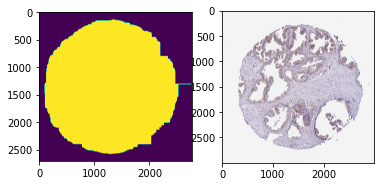

118 131


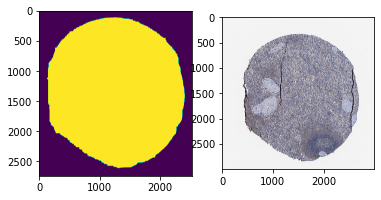

101 136


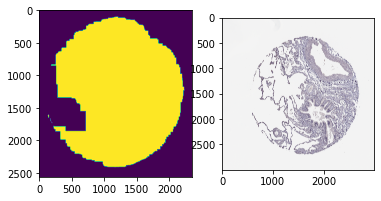

69 128


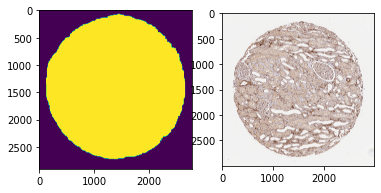

162 150


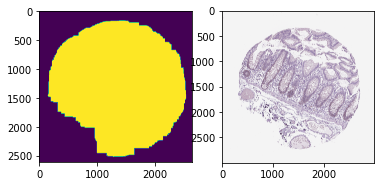

In [10]:

a = [np.array(Image.open(mpath+f'/hubmap-organ-segmentation/train_images/{str(j[0])}.tiff')) for j in organ_example]
rand = random.Random()
rand.seed(2022)
for im in a:
    m = otsu_mask_dilated(Image.fromarray(im),np.ones((10, 10), np.uint8),np.ones((300, 300), np.uint8))
    #bounds = cv.boundingRec(m)
    p_h = 250
    p_w = 250
    h_slice=rand.randint(int(p_h//4),int(3*p_h//4))
    w_slice=rand.randint(int(p_w//4),int(3*p_w//4))
    print(h_slice,w_slice)
    m_c = get_crop_using_mask(m,m,w_slice=w_slice,h_slice =h_slice,p_h = p_h, p_w=p_w,coords=False)
    #print(m)
    #plt.show()
    #print(m_c,im.shape)
    #input("yep")

    #plt.imshow(m_c)
    fig ,axs = plt.subplots(1,2)
    axs[0].imshow(m_c)
    #im2 = Image.fromarray(a[0])

    #ImageDraw.Draw(im2).polygon([tuple(u) for u in masks[0][0]], outline=1, fill=1)
    axs[1].imshow(im)

    plt.show()
    

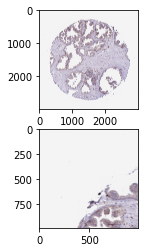

In [11]:
a = [np.array(Image.open(mpath+f'/hubmap-organ-segmentation/train_images/{str(j[0])}.tiff')) for j in organ_example]
#test 
masked = maskPIL(a[0].shape[:2],masks[0])

im = a[0]
im1 = np.rot90(a[0],1)
#im[masked] = (0,0,0)
fig ,axs = plt.subplots(2,1)
axs[0].imshow(Image.fromarray(im))
#im2 = Image.fromarray(a[0])

#ImageDraw.Draw(im2).polygon([tuple(u) for u in masks[0][0]], outline=1, fill=1)
axs[1].imshow(im1[10:1000,10:1000])

Simple tiling function

In [12]:
def dataloader_segment_rand_with_mask(image, masks, annotations, batch_size=20, height = 256, width = 256, tries = 10, percent_of_sample=0.75, masked = None, random = True):
    
    ###Create masks###
    if masked is None:
        masked = maskPIL(image.shape,masks)
    batch = []
    
    #random segment sampling
    if random:
        for i in range(tries):
            h = random.randint(0,image.shape[0]-height)
            w = random.randint(0,image.shape[0]-width)
            if check_mask_included(masked,h,w,height,width):
                batch.append((h,w))
    #divide the image into height*width sized overlapping segments
    else:
        #figure out how many segments and whats hte overlap
        height_n = int(image.shape[0]/height)
        height_excess = image.shape[0]%height
        width_n = int(image.shape[1]/width)
        width_excess = image.shape[1]%width
        height_coords = []
        
        #we will pad the edge
        height_coords = range(0,image.shape[0],height)
        width_coords = range(0,image.shape[1],width)
        batch = list(itertools.combinations(height_coords,width_coords))
            
        
    return batch


Need stains of organs with different techniques

In [13]:
#checking other possible datasets for stains


We will try 2 concepts:
1. Predicting indiscriminant of organ with only one model
2. Training a model for each organ seperatly

Simple UNet to get barebones started

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        #self.in_ch = in_ch
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,1,1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch,3,1,1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=False),
        )
        
    def forward(self,x):
        #print(x.shape)#self.in_ch)
        inter = self.conv(x) 
        #print(inter.shape)
        return inter

class UNET(nn.Module):
    def __init__(self,in_ch=3,out_ch=1,features=[64,128,256,512]):
        super(UNET,self).__init__()
        self.descend = nn.ModuleList()
        self.ascend = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        for f in features:
            self.descend.append(DoubleConv(in_ch,f))
            in_ch = f
            
        for f in reversed(features):
            self.ascend.append(nn.ConvTranspose2d(f*2,f,kernel_size=2,stride=2))
            self.ascend.append(DoubleConv(f*2,f))
            
        self.bottleneck = DoubleConv(features[-1],features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],out_ch,kernel_size = 1)
        
    def forward(self,x):
        skip_connections = []
        #print(x.shape)
        for d in self.descend:
            #print(x.shape)
            x = d(x)
            #print(x.shape)
            skip_connections.append(x)
            #print(x.shape)
            x = self.pool(x)
            #print(x.shape)
        #print(2)
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        #print(3)
        for idx in range(0,len(self.ascend),2):
            x = self.ascend[idx](x)
            skip_connection = skip_connections[idx//2]
            #print(4+idx-1)
            if x.shape != skip_connection.shape:
                x = TF.resize(x,size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x),dim=1) ####!!!!!!!!!! google
            x = self.ascend[idx+1](concat_skip)
            
        return self.final_conv(x)
    
def test():
    x = torch.randn((3,1,161,161))
    model = UNET(in_ch=1,out_ch=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape
    
test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [15]:
#loss from the interwebs
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

Data

TODO:
1. account for crops of images
2. account for transforms of images(should be done on the fly vs preprocess (can slow down training) 

In [78]:
from torch.utils.data import Dataset

#implement patch locations in the dataset!!!!

class HistoDataset(Dataset):
    #crops will be rectangular 
    def __init__(self,im_dir,mask_dir,labels,transform=None,crop_h = -1):
        self.im_dir = im_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.labels = pd.read_csv(labels)
        self.no_mirror = 4
        self.no_rot = 4
        self.crop_h = crop_h
        self.crop_w = crop_h
        self.rand = random.Random()
        rand.seed(2022)
        #self.path_otsud = "./otsu"
        
        
        #need to add the pre transformed images this should be probs done befor training to cut down on costs
        
        if crop_h == -1:
            #we are using whole images
            series = [1]*len(self.labels)
            self.labels.insert(len(self.labels.columns),'len',series)
        else:
            #we will be using crops
            series = []
            padding_h = []
            padding_w = []
            slice_w = []
            slice_h = []
            crop_size = []
            #indexes = []
            #calc masks for tissue images and get the crop to calc amount of tiles(non overlaping with 0 padding)
            pr = False
            for ix, im in self.labels.iterrows():
                im_path = os.path.join(self.im_dir, str(im.id) + ".tiff")
                image = Image.open(im_path).convert("RGB")

                m = otsu_mask_dilated(image,np.ones((10, 10), np.uint8),np.ones((300, 300), np.uint8))
                m_c = get_crop_of_mask(m)
                y_amount = m_c.shape[0] // self.crop_h #how many crops we can fit in without overlap, we want to get crops that include the tissue 
                
                #PADDING NEKI NI URED TODO
                p_h = self.crop_h - m_c.shape[0] % self.crop_h
                    
                x_amount = m_c.shape[1] // self.crop_w
                
                p_w = self.crop_w - m_c.shape[1] % self.crop_w
                if not pr:
                    print(m_c.shape,y_amount,x_amount)
                pr = True
                #for now the transforms are only:
                #    1-rotate 90(4)
                #    2-mirror 4(originial,h,v,h+v)
                #    3-amount of non overlaping tiles
                series.append(self.no_mirror*self.no_rot*(y_amount + 1 if p_h>0 else 0 )*(x_amount + 1 if p_w>0 else 0 ))
                padding_w.append(p_w)
                slice_w.append(self.rand.randint(int(p_w//4),int(3*p_w//4)))
                padding_h.append(p_h)
                slice_h.append(self.rand.randint(int(p_h//4),int(3*p_h//4)))
                crop_size.append(m_c.shape)
            self.labels.insert(len(self.labels.columns),'len',series)
            self.labels.insert(len(self.labels.columns),'padding_w',padding_w)
            self.labels.insert(len(self.labels.columns),'slice_w',slice_w)
            self.labels.insert(len(self.labels.columns),'padding_h',padding_h)
            self.labels.insert(len(self.labels.columns),'slice_h',slice_h)
            self.labels.insert(len(self.labels.columns),'crop_size',crop_size)
                    
            
        
    def __len__(self):
        #print(self.labels)
        return self.labels.loc[:,'len'].sum()
    
    def __getitem__(self,index):
        #print(self.labels.iloc[index].id)
        #need to convert index to image + crop of image
        l,index = self.convert_index(index)
        im_path = os.path.join(self.im_dir, str(l.id) + ".tiff")
        mask_path = os.path.join(self.mask_dir, str(l.id) + ".json") #to rabmo spremenit!!!! je JSON in ni actual slika
        image = Image.open(im_path).convert("RGB")
        im = image
        x,y = image.size
        #get random crop of image based on some params TODO
        
        
        masks = json.load(open(mask_path))
        #print(image.shape)
        mask = np.array(maskPIL((y,x),masks,to_array =False).convert("L"),dtype=np.float32)
        mask[mask==255.0] = 1
        
        
        if self.transform is not None:
            #TODO OPTIM: in creating the dataset save the masked and cropped images otsu_mask takes alot of time
            m = otsu_mask_dilated(image,np.ones((10, 10), np.uint8),np.ones((300, 300), np.uint8))
            #bounds = cv.boundingRec(m)
            #slice_w = self.randint(int(l.padding_w//4),int(3*l.padding_w//4))
            #slice_h = self.randint(int(l.padding_w//4),int(3*l.padding_w//4))
            mask = get_crop_using_mask(m,mask,w_slice = l.slice_w,h_slice = l.slice_h,p_h = l.padding_h,p_w = l.padding_w)
            #mask = mask[y1:y2, x1:x2]
            image = get_crop_using_mask(m,np.array(image),w_slice = l.slice_w,h_slice = l.slice_h,p_h = l.padding_h,p_w = l.padding_w)
            #image = np.array(image)
            #image = image[y1:y2, x1:x2]
            rot,mirror,crop = self.convert_index_to_transform(index,l.len)
            #print(rot,mirror,crop)
            mask = np.rot90(mask,k=rot)
            image = np.rot90(image,k=rot)
            if mirror == 1:
                mask = np.flip(mask,axis = 0)
                image = np.flip(image,axis = 0)
            elif mirror == 2:
                mask = np.flip(mask,axis = 1)
                image = np.flip(image,axis = 1)
            else:
                mask = np.flip(mask)
                image = np.flip(image)
            y,x = self.get_crop_coord(crop,image,0,0)#l.padding_w,l.padding_h)
            #print(y,x)
            im = np.copy(image[y:y+self.crop_h,x:x+self.crop_h])
            mask = np.copy(mask[y:y+self.crop_h,x:x+self.crop_h])
            #mask[mask == 255] = 1.0
            #im = self.transform(im/255.0)
            #mask = self.transform(mask)
        
                
        return im,mask#,l

    #image comes in already padded and cropped
    def get_crop_coord(self,crop,im,pad_w,pad_h):
        #print(im.shape)
        """w1=w0 = pad_w//2
        if pad_w %2 ==1 :
            w1 = w1+1
        h1=h0 = pad_h//2
        if pad_h %2 ==1 :
            w1 = w1+1"""
        y_l,x_l = im.shape[:2]
        #y_l = pad_h + y_l
        #x_l = pad_w + x_l
        #print(pad_w,pad_h)
        y = (crop // (x_l//self.crop_h))*self.crop_h
        x = (crop % (x_l//self.crop_h))*self.crop_h
        #print(y,x)
        return int(y),int(x)
        
    
    def convert_index(self,index):
        suma = 0
        for ix, l in self.labels.iterrows():
            #print(l)
            if index <suma+l.len:
                return (l,index-suma)
            else:
                suma = suma + l.len
            
    def convert_index_to_transform(self,index,length):
        crops = length/(4*4)
        rot = index //(4*crops)
        mirror = (index %(4*crops))//crops
        crop = (index %(4*crops))%crops
        
        return rot,mirror,crop
        

In [17]:
labels = "./hubmap-organ-segmentation/train.csv"
hist = HistoDataset("./hubmap-organ-segmentation/train_images","./hubmap-organ-segmentation/train_annotations",labels,transform=True,crop_h = 250)

In [18]:
"""for i in range(1,300):
    print(hist[i][0].shape)
    plt.imshow(hist[i][0])
    plt.show()
    #input()
"""

'for i in range(1,300):\n    print(hist[i][0].shape)\n    plt.imshow(hist[i][0])\n    plt.show()\n    #input()\n'

In [19]:
def convert_index_to_transform(index,length):
        crops = length/(4*4)
        rot = index //(4*crops)
        mirror = (index %(4*crops))//crops
        crop = (index %(4*crops))%crops
        
        return rot,mirror,crop
    
def convert_index(df,index):
        suma = 0
        for ix, l in df.iterrows():
            #print(l)
            if index <suma+l.len:
                return (l.id,index-suma)
            else:
                suma = suma + l.len
    
df = pd.DataFrame()
df.insert(0,'len',[15,12,33,14,3,4])
df.insert(0,'id',[0,1,2,3,4,5])
for i in range(df.loc[:,'len'].sum()):
    print(convert_index(df,i))

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2, 29)
(2, 30)
(2, 31)
(2, 32)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(4, 0)
(4, 1)
(4, 2)
(5, 0)
(5, 1)
(5, 2)
(5, 3)


utils

In [20]:
from torch.utils.data import DataLoader,Subset
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("SAVING MODEL")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model):
    print("LOADING MODEL")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders1(
    ds,
    transform,
    val_transform,
    batch_size = 16,
    val_split = 0.2,
    shuffle_ds = True,
    random_seed= 2022,
    num_workers = 4,
    pin_memory = True
):
    
    indices = list(range(len(ds)))
    split = int(np.floor(val_split*len(ds)))
    if shuffle_ds:
        np.random.seed(2022)
        np.random.shuffle(indices)
    train_ids = indices[split:]
    val_ids = indices[:split]
    
    #train_sampler = SubsetRandomSampler(train_ids)
    #val_sampler = SubsetRandomSampler(val_ids)
    train_split = Subset(ds, train_ids)
    test_split = Subset(ds, val_ids)
    
    train_loader = DataLoader(
        ds,
        batch_size = batch_size,
        #sampler = train_sampler,
        num_workers = num_workers,
        pin_memory = pin_memory,
        #shuffle = True,
    )
    
    val_loader = DataLoader(
        ds,
        batch_size = batch_size,
        #sampler = val_sampler,
        num_workers = num_workers,
        pin_memory = pin_memory,
        #shuffle = True,
    )
    
    return (ds,train_loader,val_loader)    

def get_loaders(
    train_dir,
    train_maskdir,
    transform,
    val_transform,
    batch_size = 16,
    val_split = 0.2,
    shuffle_ds = True,
    random_seed= 2022,
    num_workers = 4,
    pin_memory = True
):
    ds = HistoDataset(
        train_dir,
        "./hubmap-organ-segmentation/train_annotations",
        labels,
        transform=transform,
        crop_h = 250
    )
    indices = list(range(len(ds)))
    split = int(np.floor(val_split*len(ds)))
    if shuffle_ds:
        np.random.seed(2022)
        np.random.shuffle(indices)
    train_ids = indices[split:]
    val_ids = indices[:split]
    
    #train_sampler = SubsetRandomSampler(train_ids)
    #val_sampler = SubsetRandomSampler(val_ids)
    train_split = Subset(ds, train_ids)
    test_split = Subset(ds, val_ids)
    
    train_loader = DataLoader(
        ds,
        batch_size = batch_size,
        #sampler = train_sampler,
        num_workers = num_workers,
        pin_memory = pin_memory,
        #shuffle = True,
    )
    
    val_loader = DataLoader(
        ds,
        batch_size = batch_size,
        #sampler = val_sampler,
        num_workers = num_workers,
        pin_memory = pin_memory,
        #shuffle = True,
    )
    
    return (ds,train_loader,val_loader)

In [29]:

import torch.optim as optim
import tqdm


lr = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
N_EPOCHS = 3
N_WORKERS = 2
IM_H = 160
IM_W = 240
PIN_MEM = True
LOAD_MODEL = True
TRAIN_IM_DIR = "./hubmap-organ-segmentation/train_images"
TRAIN_MASK_DIR = "./hubmap-organ-segmentation/train_annotations"


def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm.tqdm(loader)
    
    for batch_i, (data,targets) in enumerate(loop):
        #print(data,targets)
        data= data.float()
        data = data.to(device = DEVICE)
        targets = targets.float().unsqueeze(1).to(device = DEVICE)
        
        with torch.cuda.amp.autocast():
            preds = model(data)
            targets = torch.squeeze(targets,1)
            loss = loss_fn(preds,targets)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())
        
        
    
    
def main():
    train_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    val_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    
    model = UNET(in_ch=3,out_ch=1).to(DEVICE)
    model = model.float()
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),lr=lr)

    
    """train_dir,
    train_maskdir,
    transform,
    val_transform,
    batch_size = 16,
    val_split = 0.2,
    shuffle_ds = True,
    random_seed= 2022,
    num_workers = 4,
    pin_memory = True"""
    
    ds,train_loader,val_loader = get_loaders(
        TRAIN_IM_DIR,
        TRAIN_MASK_DIR,
        train_transforms,
        val_transforms,
        batch_size=BATCH_SIZE,
        num_workers = N_WORKERS,
        pin_memory = PIN_MEM
    )
    
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(N_EPOCHS):
        print(epoch)
        train(train_loader, model, optimizer, loss_fn,scaler)
        

In [79]:
train_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
val_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

model = UNET(in_ch=3,out_ch=1).to(DEVICE)
model = model.float()
loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)


"""train_dir,
train_maskdir,
transform,
val_transform,
batch_size = 16,
val_split = 0.2,
shuffle_ds = True,
random_seed= 2022,
num_workers = 4,
pin_memory = True"""

ds,train_loader,val_loader = get_loaders(
    TRAIN_IM_DIR,
    TRAIN_MASK_DIR,
    train_transforms,
    val_transforms,
    batch_size=1,
    num_workers = N_WORKERS,
    pin_memory = PIN_MEM
)

scaler = torch.cuda.amp.GradScaler()

(2457, 2673) 9 10


  0%|          | 0/665584 [00:00<?, ?it/s]

(0, 0, 0, 0)
torch.Size([250, 250, 3])


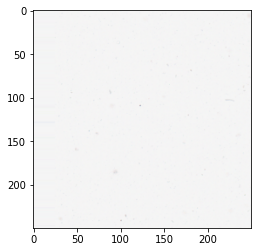

 10%|▉         | 63504/665584 [1:46:21<16:48:22,  9.95it/s]


KeyboardInterrupt: 

In [80]:
loop = tqdm.tqdm(train_loader)
size = (0,0,0,0)
print(size)
for batch_i,(data,targets) in enumerate(loop):
    if size != data[0].shape:
        size = data[0].shape
        print(size)
        plt.imshow(data[0])
        plt.show()



(2500, 2750, 3)
(250, 250, 3)
(2500, 2750, 3)
id                                                              10044
organ                                                        prostate
data_source                                                       HPA
img_height                                                       3000
img_width                                                        3000
pixel_size                                                        0.4
tissue_thickness                                                    4
rle                 1459676 77 1462675 82 1465674 87 1468673 92 14...
age                                                              37.0
sex                                                              Male
len                                                              1760
padding_w                                                          77
slice_w                                                            20
padding_h                                   

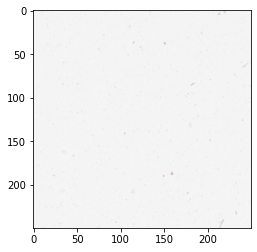

In [76]:
#gre čez tazadno vrstico kljub temu da je prazna
print(ds[101][0].shape)
#print(ds[101][2])
plt.imshow(ds[101][0])
plt.show()

In [ ]:
for epoch in range(N_EPOCHS):
        print(epoch)
        train(train_loader, model, optimizer, loss_fn,scaler)

option:
just rpedict the edge no need to predict the inside(use a thicker line for edge and just fill in the poly you get)